In [1]:
from sys import path
from os.path import relpath, realpath, abspath, join, exists
from itertools import product

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import h5py

pd.set_option('display.max_rows', 999)

In [2]:
from thesis_v2 import dir_dict
from thesis_v2.data import load_data_helper
from thesis_v2.training_extra.transfer_learning.meta import fetch_meta
from thesis_v2.training_extra.transfer_learning.analysis import collect_one_setting

In [3]:
folder_to_check = 'scripts/training/crcns_pvc8_large/transfer_learning_factorized_vgg'
path.insert(0, join(dir_dict['root'], folder_to_check))
from submit import param_iterator, sparse_list, feature_file_name
from key_utils import keygen

num_sparse = len(sparse_list)

In [4]:
from thesis_v2.data.prepared.crcns_pvc8 import process_crcns_pvc8_neural_data
from strflab.stats import cc_max

def get_cc_max():
    data = process_crcns_pvc8_neural_data(window_size='large',
                                          natural_only=True,
                                          centered=True,
                                          mean=False)
#     print(data.shape)
    data = data.transpose((2,1,0))
    print(data.shape)
    return cc_max(data)

cc_max_all_neurons = get_cc_max()

assert cc_max_all_neurons.shape == (221,)
good_mask = np.isfinite(cc_max_all_neurons)
# assert np.all(cc_max_all_neurons > 0)
print(good_mask.sum())  # # 220, so one neuron is bad.
assert np.all(cc_max_all_neurons[good_mask] > 0)

# notice that if you do `(cc_max_all_neurons > 0)`, you get "RuntimeWarning: invalid value encountered in greater".

(221, 20, 540)
220


In [5]:
def load_everything():
    _df_collect = []
    argmax_all = []
    for idx, param in enumerate(param_iterator(include_sparse=False)):
        if idx % 5 == 0:
            print(idx)
        assert param['split_seed'] == 0 and param['model_seed'] == 0
        
        # get meta
        with h5py.File(feature_file_name, 'r') as f_feature:
            meta_this = fetch_meta(f_feature['large/' + param['suffix']], 'large/' + param['suffix'])
        assert meta_this['dataset'] == 'large'
        assert meta_this['layer_unroll'] == 0
        
        performance_result = collect_one_setting(
            sparse_list = sparse_list,
            keygen=keygen,
            param=param,
            num_neuron=221,
        )
        
        assert performance_result['test_best'].shape == (221,)
        
        
        bn = meta_this['network'].endswith('_bn')
        if bn:
            network_proper = meta_this['network'][:-3]
        else:
            network_proper = meta_this['network']
       
        _df_collect.append({
            'network': network_proper,
            'shuffle_type': param['shuffle_type'],
            'scale': meta_this['setting'],
            'loss_type': param['loss_type'],
            'act_fn': param['act_fn'],
            'layer': '{:02d}.{}'.format(meta_this['layer_idx'], meta_this['layer_name']),
            'BN': bn,
            'corr_test': performance_result['test_best'].mean(),
            'corr2_normed_test': np.mean((performance_result['test_best'][good_mask]/cc_max_all_neurons[good_mask])**2),
        })
        
        # which sparsity setting is used.
        argmax_all.append(performance_result['argmax'])
        
    argmax_all = np.concatenate(argmax_all, axis=0)
    # looks good. most neurons select middle ones.
    
    # remove -1 ones.
    argmax_all = argmax_all[argmax_all!=-1]
    print(np.bincount(argmax_all)/argmax_all.size)

    _df =  pd.DataFrame(_df_collect, columns=['shuffle_type', 'network',  'scale', 'loss_type', 'act_fn', 'layer', 'BN', 'corr_test', 'corr2_normed_test'])
    _df = _df.set_index(['shuffle_type', 'network',  'scale', 'loss_type', 'act_fn', 'layer', 'BN'], verify_integrity=True)
    return _df


In [6]:
# collect all data.
# it's a series.
df_all = load_everything()

df_dict = {
    'legacy': df_all['corr_test'],
    'corr2_normed': df_all['corr2_normed_test'],
}

['vgg11/half/1.0', 'vgg11/half/2.0', 'vgg11/half/3.0', 'vgg11/half/4.0', 'vgg11/half/5.0', 'vgg11/half/6.0', 'vgg11/half_full/1.0', 'vgg11/half_full/2.0', 'vgg11/half_full/3.0', 'vgg11/half_full/4.0', 'vgg11/half_full/5.0', 'vgg11/half_full/6.0', 'vgg11/quarter_full/1.0', 'vgg11/quarter_full/2.0', 'vgg11/quarter_full/3.0', 'vgg11/quarter_full/4.0', 'vgg11/quarter_full/5.0', 'vgg11/quarter_full/6.0', 'vgg11_bn/half/1.0', 'vgg11_bn/half/2.0', 'vgg11_bn/half/3.0', 'vgg11_bn/half/4.0', 'vgg11_bn/half/5.0', 'vgg11_bn/half/6.0', 'vgg11_bn/half_full/1.0', 'vgg11_bn/half_full/2.0', 'vgg11_bn/half_full/3.0', 'vgg11_bn/half_full/4.0', 'vgg11_bn/half_full/5.0', 'vgg11_bn/half_full/6.0', 'vgg11_bn/quarter_full/1.0', 'vgg11_bn/quarter_full/2.0', 'vgg11_bn/quarter_full/3.0', 'vgg11_bn/quarter_full/4.0', 'vgg11_bn/quarter_full/5.0', 'vgg11_bn/quarter_full/6.0', 'vgg16/half/2.0', 'vgg16/half/3.0', 'vgg16/half/4.0', 'vgg16/half/5.0', 'vgg16/half/6.0', 'vgg16/half/7.0', 'vgg16/half/8.0', 'vgg16/half/9.0

In [7]:
# only focus on the split seed == 'legacy' part.

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

from thesis_v2.plots.basic import scatter
from thesis_v2.plots.util import savefig

In [9]:
def plot_scatter(df_this, key1, key2, level, xlabel, ylabel, key, lim):
    plt.close('all')
    fig, ax = plt.subplots(figsize=(3,3))
    
    x = df_this.xs(key1, level=level).sort_index().values
    y = df_this.xs(key2, level=level).sort_index().values
    
    selector = np.logical_and(np.isfinite(x), np.isfinite(y))
    n = selector.sum()
    assert n > 0
    
    scatter(ax, x[selector], y[selector], xlabel, ylabel, xlim=lim, ylim=lim)
    # TODO set tick labels.
    ax.text(0.05, 0.95, f'N={n}',
            horizontalalignment='left',
            verticalalignment='top', transform=ax.transAxes)
    
    # adjust figure size to make sure the aspect ratio is correct.
    fig.subplots_adjust(left=0.2,bottom=0.2,right=0.9,top=0.9)
    
    # save fig.
    savefig(fig, f'crcns_pvc8_large/transfer_learning_factorized_vgg/hyperparameter_no_size_change/{key}.pdf')
    
    plt.show()

In [10]:
# df_to_use = df_to_use.xs('relu', level='act_fn')
# if you uncomment this and replot, you can see all those outliers disappear.
# remember to comment out `plot_scatter(df_to_use, 'softplus', 'relu', 'act_fn', 'softplus', 'relu', 'act')`, as act_fn column disappears then.

In [11]:
def get_all_scatter(df_to_use_this, prefix='', lim=(0.3,0.8)):
    
    # comments match `corr_test` metrics
    plot_scatter(df_to_use_this, 'half_full', 'half', 'scale', 'half_full', 'half', prefix + 'input_size', lim)
    # not very useful, as layers are not matched.
    
    
    
    plot_scatter(df_to_use_this, 'softplus', 'relu', 'act_fn', 'softplus', 'relu', prefix + 'act', lim)
    # relu a bit better. but this is not the case for 8K data. maybe small size effect here.
    
    
    plot_scatter(df_to_use_this, True, False, 'BN', 'bn', 'no bn', prefix + 'bn', lim)
    # almost the same. pick BN to be consistent with other parts.
    
    
    # loss_type
    plot_scatter(df_to_use_this, 'poisson', 'mse', 'loss_type', 'poisson', 'mse', prefix + 'loss_type', lim)
    # outliers (those with ~0 performance points) are all due to softplus. check line `df_to_use = df_to_use.xs('relu', level='act_fn')`.

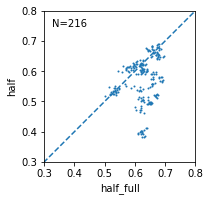

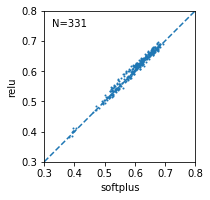

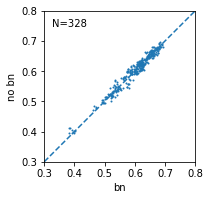

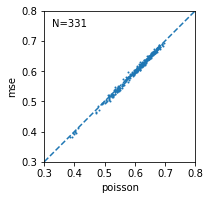

In [12]:
get_all_scatter(df_dict['legacy'])

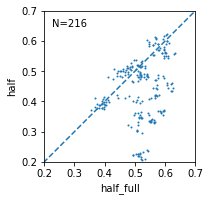

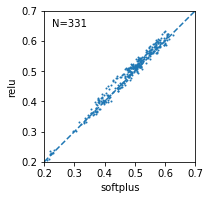

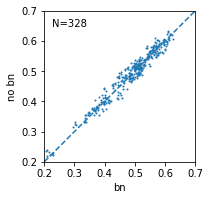

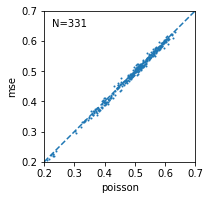

In [13]:
get_all_scatter(df_dict['corr2_normed'], prefix='corr2normed_', lim=(0.2, 0.7))

In [14]:
from thesis_v2.plots.basic import labeled_line

In [15]:
# then plot corr. vs. layer stuff.
def visualize(df_to_use_this, ylim=(0.35, 0.7), prefix='', ylabel='mean corr on test set'):
    for paired_type in df_to_use_this.index.get_level_values('shuffle_type').unique():
        for net in df_to_use_this.index.get_level_values('network').unique():
            for scale in ('half', 'half_full', 'quarter_full'):
                print(paired_type, net, scale)

                df_this = df_to_use_this.xs(paired_type, level='shuffle_type').xs(net, level='network')
                df_this_shaped = df_this.xs('mse', level='loss_type').xs('softplus', level='act_fn').xs(scale, level='scale').unstack('BN').sort_index().sort_index(axis=1)


                print(df_this_shaped)
                assert df_this_shaped.columns.values.tolist() == [False, True]

                plt.close('all')

                fig, ax = plt.subplots(figsize=(6,3))

                labeled_line(ax,
                             [
                                 ('no BN', df_this_shaped.values[:,0]),
                                 ('BN', df_this_shaped.values[:,1]),
                             ],
                             [s[3:] for s in df_this_shaped.index.values],
                             xlabel='layer',
                             ylabel=ylabel,
                             ylim=ylim,
                             plot_kwargs={'marker': 'x'},
                             xticklabels_kwargs={'rotation': 45},
                            )

                fig.subplots_adjust(bottom=0.275,right=0.975,top=0.975)

                savefig(fig,
                        f'crcns_pvc8_large/transfer_learning_factorized_vgg/per_layer_performance/{prefix}{net}-{paired_type}-{scale}.pdf'
                       )
                plt.show()

legacy vgg11 half
BN             False     True 
layer                         
01.pool1    0.600367  0.598750
02.conv2_1  0.665356  0.676274
03.pool2    0.671519  0.678558
04.conv3_1  0.658263  0.675105
05.conv3_2  0.545826  0.572961
06.pool3    0.648446  0.658695


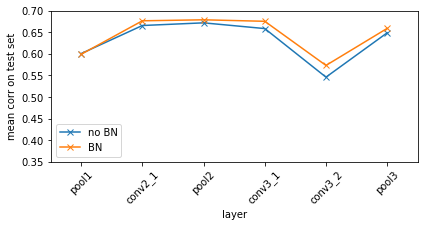

legacy vgg11 half_full
BN             False     True 
layer                         
01.pool1    0.544664  0.578789
02.conv2_1  0.642993  0.636824
03.pool2    0.659192  0.657170
04.conv3_1  0.675239  0.678741
05.conv3_2  0.643788  0.658538
06.pool3    0.652092  0.660180


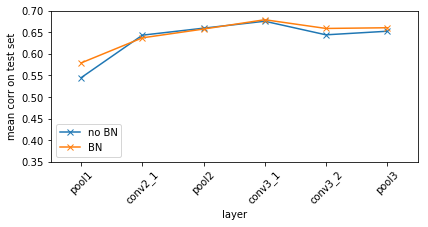

legacy vgg11 quarter_full
BN             False     True 
layer                         
01.pool1    0.620813  0.610575
02.conv2_1  0.649449  0.653667
03.pool2    0.655705  0.645866
04.conv3_1  0.635581  0.634382
05.conv3_2  0.622273  0.618397
06.pool3    0.620981  0.606119


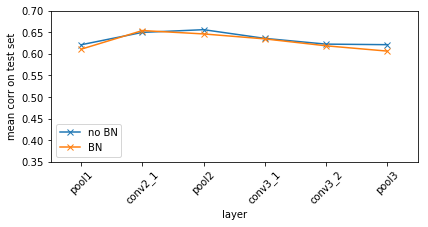

legacy vgg16 half
BN             False     True 
layer                         
02.pool1    0.614011  0.604581
03.conv2_1  0.616549  0.608088
04.conv2_2  0.590722  0.589956
05.pool2    0.642218  0.639611
06.conv3_1  0.576650  0.567114
07.conv3_2  0.518153  0.521135
08.conv3_3  0.493096  0.499435
09.pool3    0.551102       NaN


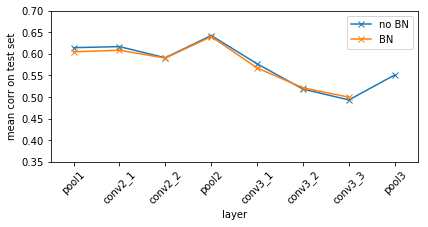

legacy vgg16 half_full
BN             False     True 
layer                         
02.pool1    0.604342  0.586432
03.conv2_1  0.616343       NaN
04.conv2_2  0.661846  0.634173
05.pool2    0.673632  0.673395
06.conv3_1  0.679396  0.682387
07.conv3_2  0.667487  0.662268
08.conv3_3  0.648441  0.652168
09.pool3    0.655176  0.648016


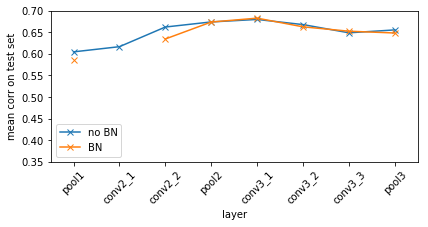

legacy vgg16 quarter_full
BN             False     True 
layer                         
02.pool1    0.644172  0.640238
03.conv2_1  0.637844  0.623448
04.conv2_2  0.663283  0.647905
05.pool2    0.660763  0.657280
06.conv3_1  0.663684  0.652458
07.conv3_2  0.630256  0.621497
08.conv3_3  0.537360  0.553833
09.pool3    0.537861  0.541025


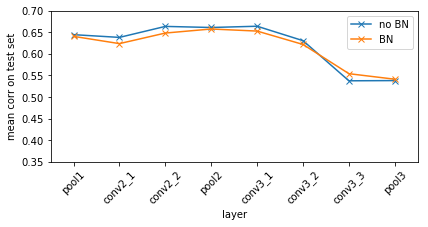

paired vgg11 half
BN             False     True 
layer                         
01.pool1    0.518027  0.523077
02.conv2_1  0.603638  0.616368
03.pool2    0.615352  0.624324
04.conv3_1  0.598640  0.612959
05.conv3_2  0.472661  0.461654
06.pool3    0.590722  0.605076


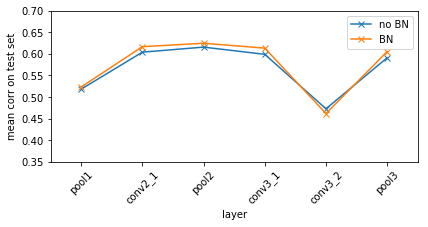

paired vgg11 half_full
BN             False     True 
layer                         
01.pool1    0.501447  0.521506
02.conv2_1  0.571671  0.582542
03.pool2    0.592018  0.606499
04.conv3_1  0.620446  0.619475
05.conv3_2  0.604472  0.628480
06.pool3    0.605045  0.617380


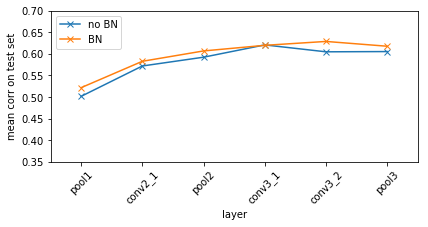

paired vgg11 quarter_full
BN             False     True 
layer                         
01.pool1    0.553355  0.531285
02.conv2_1  0.593048  0.606401
03.pool2    0.595868  0.601301
04.conv3_1  0.606822  0.602788
05.conv3_2  0.596943  0.585245
06.pool3    0.596162  0.577744


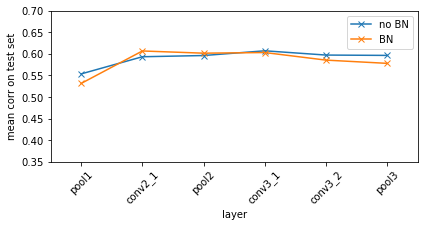

paired vgg16 half
BN             False     True 
layer                         
02.pool1    0.523706  0.521633
03.conv2_1  0.529501  0.525285
04.conv2_2  0.535003  0.544607
05.pool2    0.591154  0.598035
06.conv3_1  0.497137  0.491968
07.conv3_2  0.394017  0.383608
08.conv3_3  0.393845  0.390809
09.pool3    0.506885  0.501425


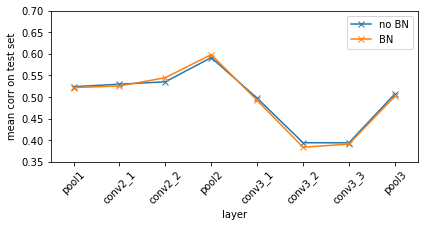

paired vgg16 half_full
BN             False     True 
layer                         
02.pool1    0.531421  0.536285
03.conv2_1  0.542556  0.517447
04.conv2_2  0.614764  0.587505
05.pool2    0.620601  0.627146
06.conv3_1  0.629094  0.640848
07.conv3_2  0.622632  0.624478
08.conv3_3  0.609163  0.618839
09.pool3    0.610370  0.620826


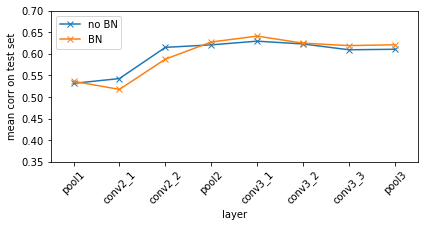

paired vgg16 quarter_full
BN             False     True 
layer                         
02.pool1    0.568980  0.564913
03.conv2_1  0.576163  0.561671
04.conv2_2  0.616587  0.597078
05.pool2    0.624358  0.610293
06.conv3_1  0.621981  0.624151
07.conv3_2  0.589324  0.586497
08.conv3_3  0.519314  0.514552
09.pool3    0.519575  0.514767


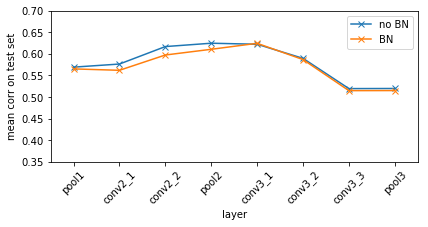

In [16]:
visualize(df_dict['legacy'])
# combine BN.

legacy vgg11 half
BN             False     True 
layer                         
01.pool1    0.479482  0.479572
02.conv2_1  0.583244  0.603267
03.pool2    0.590653  0.605316
04.conv3_1  0.570746  0.600878
05.conv3_2  0.409294  0.443415
06.pool3    0.554339  0.571604


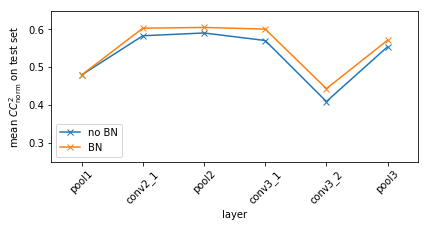

legacy vgg11 half_full
BN             False     True 
layer                         
01.pool1    0.409672  0.456726
02.conv2_1  0.548186  0.539697
03.pool2    0.575281  0.570560
04.conv3_1  0.597346  0.604500
05.conv3_2  0.548095  0.570926
06.pool3    0.560988  0.574974


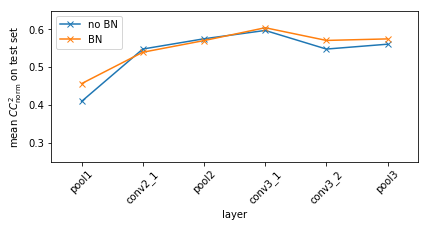

legacy vgg11 quarter_full
BN             False     True 
layer                         
01.pool1    0.514772  0.500972
02.conv2_1  0.555925  0.564475
03.pool2    0.564931  0.551239
04.conv3_1  0.534142  0.531555
05.conv3_2  0.516244  0.508138
06.pool3    0.511904  0.489163


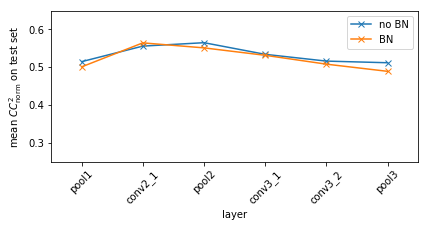

legacy vgg16 half
BN             False     True 
layer                         
02.pool1    0.502843  0.488123
03.conv2_1  0.507804  0.498407
04.conv2_2  0.477016  0.473685
05.pool2    0.550698  0.542599
06.conv3_1  0.455471  0.443022
07.conv3_2  0.369397  0.368666
08.conv3_3  0.332842  0.338213
09.pool3    0.409974       NaN


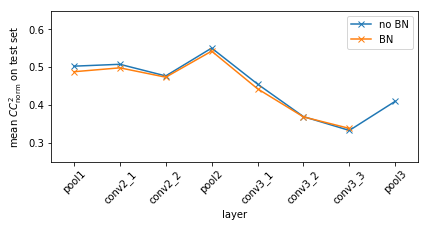

legacy vgg16 half_full
BN             False     True 
layer                         
02.pool1    0.488361  0.466258
03.conv2_1  0.504651       NaN
04.conv2_2  0.576769  0.535883
05.pool2    0.596186  0.594938
06.conv3_1  0.604617  0.610122
07.conv3_2  0.582544  0.576421
08.conv3_3  0.553581  0.561679
09.pool3    0.565357  0.553095


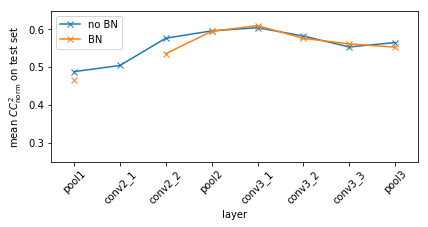

legacy vgg16 quarter_full
BN             False     True 
layer                         
02.pool1    0.550318  0.542461
03.conv2_1  0.536875  0.517511
04.conv2_2  0.578901  0.553910
05.pool2    0.574133  0.570342
06.conv3_1  0.579948  0.560358
07.conv3_2  0.526097  0.511916
08.conv3_3  0.395318  0.414341
09.pool3    0.397632  0.398106


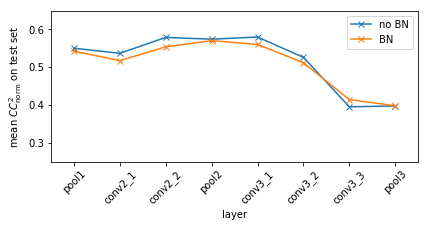

paired vgg11 half
BN             False     True 
layer                         
01.pool1    0.372006  0.378819
02.conv2_1  0.485347  0.505619
03.pool2    0.505322  0.517245
04.conv3_1  0.480347  0.501887
05.conv3_2  0.314831  0.295065
06.pool3    0.467421  0.487660


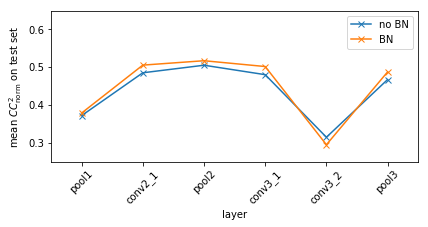

paired vgg11 half_full
BN             False     True 
layer                         
01.pool1    0.356382  0.380827
02.conv2_1  0.441195  0.459504
03.pool2    0.470095  0.489570
04.conv3_1  0.513132  0.511644
05.conv3_2  0.486469  0.521904
06.pool3    0.489676  0.507860


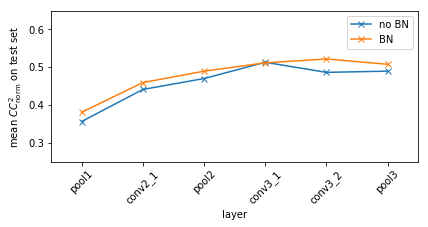

paired vgg11 quarter_full
BN             False     True 
layer                         
01.pool1    0.421229  0.392121
02.conv2_1  0.475773  0.492082
03.pool2    0.474962  0.484549
04.conv3_1  0.493387  0.484411
05.conv3_2  0.481160  0.455700
06.pool3    0.476655  0.447554


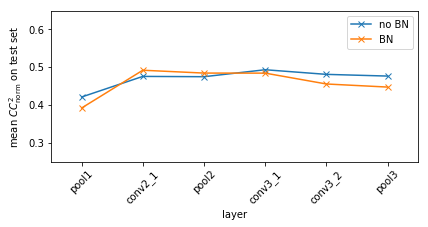

paired vgg16 half
BN             False     True 
layer                         
02.pool1    0.379292  0.375524
03.conv2_1  0.386862  0.381072
04.conv2_2  0.396597  0.410372
05.pool2    0.468492  0.479285
06.conv3_1  0.344837  0.336278
07.conv3_2  0.220625  0.209505
08.conv3_3  0.221939  0.219508
09.pool3    0.354514  0.344162


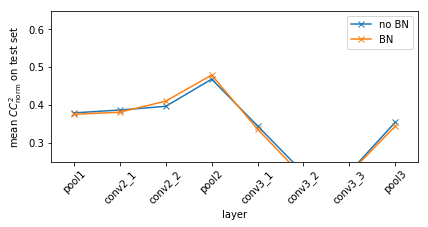

paired vgg16 half_full
BN             False     True 
layer                         
02.pool1    0.391043  0.397439
03.conv2_1  0.405391  0.369283
04.conv2_2  0.504574  0.466620
05.pool2    0.509531  0.521494
06.conv3_1  0.524535  0.545348
07.conv3_2  0.514449  0.520204
08.conv3_3  0.493368  0.510392
09.pool3    0.497471  0.512549


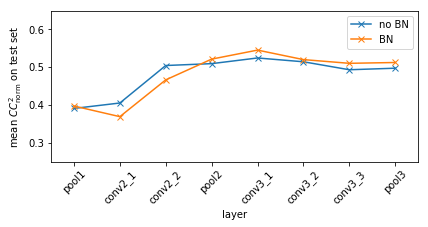

paired vgg16 quarter_full
BN             False     True 
layer                         
02.pool1    0.436220  0.434857
03.conv2_1  0.449944  0.425901
04.conv2_2  0.507341  0.476497
05.pool2    0.521845  0.498679
06.conv3_1  0.512328  0.519230
07.conv3_2  0.464357  0.459734
08.conv3_3  0.371171  0.361684
09.pool3    0.372631  0.363440


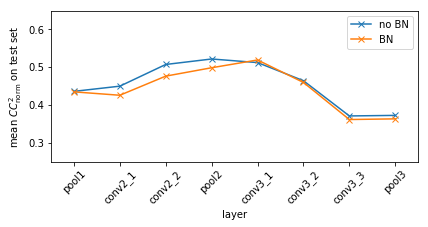

In [17]:
visualize(df_dict['corr2_normed'], prefix='ccnormed2-', ylim=(0.25, 0.65), ylabel='mean $CC_{\\mathrm{norm}}^2$ on test set')